# Malaria Project

## Introduction 
##### Members
   Sebastian Schwarz
   Youssef Hantous

##### Project Description
The aim of this project is to study the distribution and evolution of anophenile vectors of Malaria in Africa. 
The dataset is a compilation of all available mosquito studies from 1898 to 2016. It was compiled in *Kyalo D, Amratia P, Mundia CW et al. A geo-coded inventory of anophelines in the Afrotropical Region south of the Sahara: 1898-2016*, published in 2017 with the help of the KEMRI-Wellcome Trust, in collaboration with many major research agencies on Malaria. 

This data should help better understand how malaria developped in the past century and what species are primarily associated with its expansion. 

We want to present this data in a clear fashion, showing trends in the evolution and the spread of anopheniles in Africa, and try to predict the future repartition of main malaria transmitting species. 


##### Data Source 
- Kaggle: https://www.kaggle.com/jboysen/malaria-mosquito 
- Dataverse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/NQ6CUN

The paper describing how this dataset was compiled can be found here: https://wellcomeopenresearch.org/articles/2-57/v1 

##### Github Repository
- https://github.com/SebastianS09/Malaria (peut être pas) 


## Code
##### Data Import and cleaning

In [5]:
import numpy as np 
import pandas as pd 

data_raw = pd.read_csv("https://raw.githubusercontent.com/SebastianS09/Malaria/master/Data/Malaria.csv")

print("The dataset has ",data_raw.shape[0],"rows and ",data_raw.shape[1],"columns")

data_raw.head(10)


The dataset has  13464 rows and  41 columns


,Country,GAUL_Admin1,GAUL_Admin2,Full_Name,Lat,Long,LatLong_Source,YeStart,YeEnd,An gambiae_complex,...,An rufipes,An coustani s.l,An ziemanni,An paludis,Adults/Larvae,Sampling_Methods,Species_Identification,Other sib species names,Other Anopheline species,Source_Title
0,Angola,Bengo,Dande,Barra do Dande,-8.4730,13.3620,Encarta,1967,1967,Y,...,NaN,NaN,NaN,NaN,"Adults, Larvae","HLC, HBC, LC",M,NaN,NaN,Ribeiro H & Ramos HC (1975). Research on the m...
1,Angola,Bengo,Dande,Boa Vista,-8.5990,13.5660,Encarta,1987,1987,Y,...,NaN,NaN,NaN,NaN,"Adults, Larvae","PSC, LC",M,NaN,NaN,Ramos L (1988). Memorandum sent to Director Ge...
2,Angola,Bengo,Dande,Cabungo,-8.5667,13.5000,Other,2002,2002,Y,...,NaN,NaN,NaN,NaN,Adults,"IR, Bednet traps","M, PCR",NaN,NaN,"Calzetta M, Santolamazza F, Carrara GC, Cani P..."
3,Angola,Bengo,Dande,Lifune,-8.4000,13.4490,Encarta,1970,1970,NaN,...,NaN,Y,Y,NaN,"Adults, Larvae","HLC, ABC, LC",M,NaN,NaN,Ribeiro H & Ramos HC (1975). Research on the m...
4,Angola,Bengo,Dembos,Dembos,-8.5156,14.5189,Google Earth,1940,1940,Y,...,NaN,NaN,NaN,NaN,Unknown,Unknown,M,NaN,NaN,De Mesquita B (1942). Considerações sobre o im...
5,Angola,Bengo,Icolo E Bengo,Bom Jesus,-9.1660,13.5660,Encarta,1952,1955,NaN,...,NaN,Y,Y,NaN,Adults,"IR, HLC",M,NaN,NaN,Gandara AF (1956). Subsido para o estude dos '...
6,Angola,Bengo,Icolo E Bengo,Icolo e Bengo,-9.2500,13.7333,Other,1940,1940,Y,...,NaN,NaN,NaN,NaN,Unknown,Unknown,M,NaN,NaN,Ribiero L (1942). Notas sobre aspectos nosogra...
7,Angola,Bengo,Icolo E Bengo,Kilunda,-8.9268,13.5878,Other,2001,2002,NaN,...,NaN,NaN,NaN,NaN,Adults,IR,"M, CBS",NaN,NaN,"Boccolini D, Carrara GC, Dia I, Fortes F, Cani..."
8,Angola,Bengo,Icolo E Bengo,Lagoa Banda,-8.8503,13.5842,Google Earth,1965,1965,Y,...,NaN,Y,Y,NaN,"Adults, Larvae","HLC, HBC, ABC, LC",M,NaN,NaN,Ribeiro H & Ramos HC (1975). Research on the m...
9,Angola,Bengo,Icolo E Bengo,Mazozo,-9.1020,13.6220,Encarta,1970,1970,Y,...,NaN,NaN,NaN,NaN,"Adults, Larvae","HLC, ABC, LC",M,NaN,NaN,Ribeiro H & Ramos HC (1975). Research on the m...


One observation of the data set is associated with one location, time and a source study. 
The location information is displayed as follows: 
- Country and Village name
- GAUL administrative regions (https://en.wikipedia.org/wiki/Global_Administrative_Unit_Layers) which are a unified spatial admnistrative unit system
- Geospatial coordinates and source

Each survey has a start and an end date. We will audit this in the next cell

There is supplementary information on the survey namely:
- Adults/Larvae: whether the survey was conducts on adults or larvae (live in water), sometimes unknown
- Sampling methods: how the speciemens where caught 
- Identification methods: how they were attributed to one species
- Other names and other species: if the species found also have other names and if they were other species present than the main 36 quoted
Details of the abreviations can be found here: https://github.com/SebastianS09/Malaria/blob/master/Data/Africa%20Vectors%20database_1898-2016_key.pdf

We will explore this supplementary information later

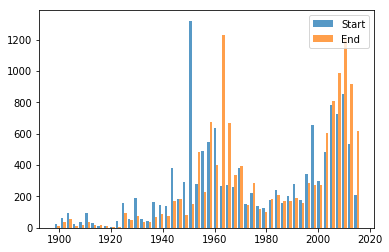

In [15]:
import matplotlib.pyplot as plt
dates = np.vstack([data_raw["YeStart"],data_raw["YeEnd"]]).T
plt.hist(dates,bins=50, alpha=0.75, label=['Start', 'End'])
plt.legend(loc='upper right')
plt.show()

As we can see, most of the surveys have been executed around the 60s and in the late 2000s. 

However, the start year and the end year do not always coincide, meaning that the surveys may have been run on periods extending one year. Let us look into this with more detail. 

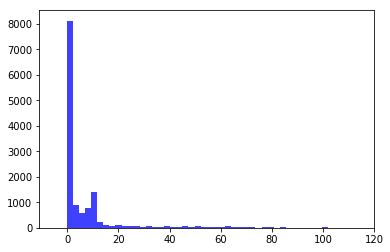

In [42]:
length = dates[:,1]-dates[:,0]
plt.hist(length, bins=50, facecolor="blue", alpha=0.75)
plt.show()

Most of the surveys have lasted for less than five years which seems reasonable. 
The fact that there is a non zero number of surveys lasting more than 20 years however is surprising. 
Let us look at this data and query the unique study titles associated to these long period surveys

In [62]:
long_survey = data_raw[["YeStart","YeEnd","Source_Title"]].query("YeEnd-YeStart>20")
pd.DataFrame(long_survey)

,YeStart,YeEnd,Source_Title
22,1963,2006,"Ribeiro H, Casaca VMR, Cochofel JALP (1964). A..."
30,1952,2005,Gandara AF (1956). Subsido para o estude dos '...
60,1940,2003,De Mesquita B (1942). Considerações sobre o im...
117,1940,2014,De Mesquita B (1942). Considerações sobre o im...
126,1940,2014,De Mesquita B (1942). Considerações sobre o im...
154,1967,2001,Ribeiro H & Ramos HC (1975). Research on the m...
164,1912,2003,Sant'Anna JF (1920). Anofelíneos de Portugal e...
181,1983,2006,Ceita JGV (1988). Relatorio de missao sobre a ...
199,1970,2002,Ribeiro H & Ramos HC (1975). Research on the m...
208,1970,2003,Ribeiro H & Ramos HC (1975). Research on the m...


In [65]:
pd.DataFrame(long_survey["Source_Title"].value_counts().sort_values(ascending = False))

,Source_Title
"Sogoba N, Vounatsou P, Bagayoko MM, Doumbia S, Dolo G, Gosoniu L, Traore SF, Toure YT, Smith T (2007). The spatial distribution of Anopheles gambiae sensu strict and An. arabiensis (Diptera: Culicidae) in Mali. Geospatial Health 2, 213-307; Sogoba N, Vounatsou P, Bagayoko MM, Doumbia S, Dolo G, Gosoniu L, Traoré SF, Smith TA, Touré YT (2008). Spatial distribution of the chromosomal forms of anopheles gambiae in Mali. Malaria Journal, 7:257; digitized occurennce and compared with actual data to idenfify those likely missed from formal search",22
"Lewis DJ (1945). Observations on the distribution and taxonomy of Culicidae (Diptera) in the Sudan. Transactions of the Royal Entomological Society of London, 95: 1-26; Lewis DJ (1956). The anopheline mosquitoes of Sudan. Bulletin of Entomological Research, 47: 475-494",14
"Lewis DJ (1956). The anopheline mosquitoes of Sudan. Bulletin of Entomological Research, 47: 475-494; Digitized from map shown in Figure 9, page 489 Google Earth to nearest towns; Awad F & Mohamed Ismail S (2015). The malaria situation in Sudan. Presentation at EMRO 11th Regional Meeting, Amman, Jordon, 22nd November 2015; Points digitized from map and names of the places estimated in Google Earth",10
"Lewis DJ (1945). Observations on the distribution and taxonomy of Culicidae (Diptera) in the Sudan. Transactions of the Royal Entomological Society of London, 95: 1-26; Lewis DJ (1956). The anopheline mosquitoes of Sudan. Bulletin of Entomological Research, 47: 475-494; Digitized from map shown in Figure 9, page 489 Google Earth to nearest towns",6
"Laveran MA (1904). Anopheles et paludisme a Madagascar. Prophylaxie du paludisme. Bulletin de l'Academie de Medecine, 52: 197-218; Grjebine A (1966). Faune de Madagascar XXII. Insectes Dipteres Culicidae Anophelinae. ORSTOM Paris, 487 pp.; assembly of previous survey data by Institute Pasteur & Others",4
"de Meillon B (1941). Estudos entomológicos da colónia de Moçambique : Relatório acerca dos vectores do paludismo em algumas partes da África Oriental Portuguesa, com sugestoes para o seu combate. Lourenço Marques : Imprensa Nacional de Moçambique, pp. 313; de Meillon B & Pereira MC (1940). Notes on some anophelines (Dipt. Culicidae) from Portuguese East Africa. Moçambique-Documentário Trimestral, 23: 69-107; Soeiro AN (1952). O sezonismo em Moçambique : contribuição para o estudo epidemiológico. Anais do Instituto de Medicina Tropical, 9: 343-389; op cit report by de Meillon B & Pereira MC (1940); Petrarca V, Carrara GC, Di Deco MA, Petrangeli G (1984). Osservazioni citogenetiche e biometriche sui membri del complesso Anopheles gambiae in Mozambico. Parassitologia, 26: 247-259",4
"Mourão MC (1964). Relatório da Missão de estudo e combate de endemias de São Tomé e Principe (1º semestre de 1962). Anais do Instituto de Medicina Tropical, 21: 501-539; Pinto J, Sousa CA, Gil V, Ferreira C, Gonçalves L, Lopes D, Petrarca V, Charlwood JD, do Rosário VE (2000). Malaria in São Tomé and Príncipe: parasite prevalences and vector densities. Acta Tropica, 76: 185-193",4
"Mourão MC (1964). Relatório da Missão de estudo e combate de endemias de São Tomé e Principe (1º semestre de 1962). Anais do Instituto de Medicina Tropical, 21: 501-539; Ribeiro H, Ramos HC, Pires CA (1988). Sobre os vectores da malária em São Tomé e Principe. Garcia de Orta, Série de Zoologia, 15: 135-152; Pinto J, Sousa CA, Gil V, Ferreira C, Gonçalves L, Lopes D, Petrarca V, Charlwood JD, do Rosário VE (2000). Malaria in São Tomé and Príncipe: parasite prevalences and vector densities. Acta Tropica, 76: 185-193",3
"Hamon J, Abonnenc E, Noel E (1955). Contribution à l'étude des Culicides de l'ouest du Sénégal. Annales de Parasitologie Humaine et Comparée, 30: 278-308; Diagne N, Fontenille D, Konate L, Faye O, Lamizana MT, Legros F, Molez JF, Trape JF (1994). Les anophèles du Sénégal : liste commentée et illustrée. Bulletin de la Société de Pathologie Exotique, 87: 267-277",3
"Maffi M (1960). Malaria i

Looking at this summary data, it seems that republication dates have sometimes be taken into account as end dates (see Hamon J studies for example). 

**Moving forward, we will therefore use the start date as the reference date.** We would suggest auditing these long period cases for the sake of the datasets integrity, even if it does not affect us very much here.